### Notebook Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.model_selection import train_test_split

In [133]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import xgboost as xgb

# spacy for lemmatization
import spacy

# Plotting tools
#import pyLDAvis
#import  pyLDAvis.sklearn

from tqdm import tqdm
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import string






In [54]:
#! python -m spacy download en

In [55]:
#!python -m spacy download en_core_web_lg 

In [5]:
#nlp = spacy.load('en_core_web_lg')

In [88]:
df = pd.read_csv('./winemag-data_first150k.csv')

df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


### Exploratory Data Analysis and Visualizations 1 and 2

In [7]:
df.describe(include='all')

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
count,150930.000000,150925,150930,105195,150930.000000,137235.000000,150925,125870,60953,150930,150930
unique,NaN,48,97821,30621,NaN,NaN,455,1236,18,632,14810
top,NaN,US,"86-88 This could work as a rich wine, because ...",Reserve,NaN,NaN,California,Napa Valley,Central Coast,Chardonnay,Williams Selyem
freq,NaN,62397,6,2752,NaN,NaN,44508,6209,13057,14482,374
mean,75464.500000,NaN,NaN,NaN,87.888418,33.131482,NaN,NaN,NaN,NaN,NaN
std,43569.882402,NaN,NaN,NaN,3.222392,36.322536,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,80.000000,4.000000,NaN,NaN,NaN,NaN,NaN
25%,37732.250000,NaN,NaN,NaN,86.000000,16.000000,NaN,NaN,NaN,NaN,NaN
50%,75464.500000,NaN,NaN,NaN,88.000000,24.000000,NaN,NaN,NaN,NaN,NaN
75%,113196.750000,NaN,NaN,NaN,90.000000,40.000000,NaN,NaN,NaN,NaN,NaN


In [57]:
df_country = df.groupby('country', as_index=False)['points'].mean()

In [58]:
df_country.head()

,country,points
0,Albania,88.000000
1,Argentina,85.820425
2,Australia,87.798679
3,Austria,89.118838
4,Bosnia and Herzegovina,83.000000


In [59]:
import plotly.plotly as py

data = [ dict(
        type = 'choropleth',
        locations = df_country['country'],
        z = df_country['points'],
        text = df_country['country'],
        locationmode = 'country names',
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = True,
            title = 'Mean points of<br>Countries in data'),
      ) ]

layout = dict(
    title = 'Overview of Mean Points of Countries in Data',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='winedata-world-map' )

We wanted to see the average points the various countries got in the dataset. So for that purpose, we plotted an interactive map for this purpose where we have 2 visual encodings to show the location of the countries on world map and color density to show the mean points received by them. There is another interactive feature where we can just hover over each location to see the name of the country and the exact value of mean score for it.

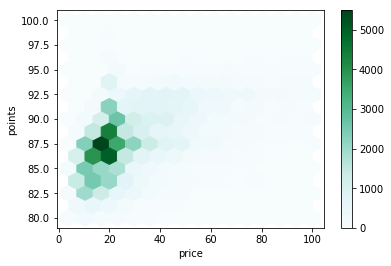

In [61]:
df[df['price']<=100].plot.hexbin(x='price', y='points', gridsize =15, sharex = False)

There is only one continuous feature in our dataset other than points itself and that is price. So we wanted to see the distribution of points v/s price. So we made a hexbin where marks are the small hexagons and channels are their relative positions and color to show the density at a certain point. This plot has an advantage over scatterplot as it overcomes the drawback of overlapping points annd we can actually identify the most dense points of the plot.

### Data Cleaning:


In [16]:
## Checking the number of null values in each feature.
df.isnull().sum()

Unnamed: 0         0
country            5
description        0
designation    45735
points             0
price          13695
province           5
region_1       25060
region_2       89977
variety            0
winery             0
dtype: int64

In [89]:
## Dropping features with more than 60% null values
df = df.dropna(thresh=df.shape[0]*0.6,how='all',axis=1)

In [90]:
df.isna().sum()

Unnamed: 0         0
country            5
description        0
designation    45735
points             0
price          13695
province           5
region_1       25060
variety            0
winery             0
dtype: int64

In [91]:
## Dropping unnamed because its essentially index
df = df.drop(['Unnamed: 0'], axis =1)

In [92]:
#df.designation.value_counts(dropna = False)

In [93]:
df.shape

(150930, 9)

In [94]:
# Remove duplicate and NA
df = df.dropna(subset=['country', 'province'])
df = df[df.duplicated('description', keep=False)]


In [95]:
df.shape

(92390, 9)

In [96]:
df.isna().sum()

country            0
description        0
designation    27768
points             0
price           8445
province           0
region_1       15855
variety            0
winery             0
dtype: int64

In [97]:
## Filling missing values  of categorical features with mode
columns = ['designation', 'region_1']
for column in df.columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [98]:
df['price'].fillna(df['price'].mean(), inplace=True)

In [99]:
df.isna().sum()

country        0
description    0
designation    0
points         0
price          0
province       0
region_1       0
variety        0
winery         0
dtype: int64

In [102]:
target = df['points']

In [103]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

In [104]:
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens



In [105]:
tqdm.pandas()
df["tokenized_description"] = df["description"].progress_apply(spacy_tokenizer)

100%|███████████████████████████████████████████████████████████████████████████| 92390/92390 [04:27<00:00, 345.55it/s]


In [106]:
## Dropping points as it is the target and description because we have its tokenized version as feature now
## dropped designation because after one hot encoding it, the dimension became too large to handle
df2 = df
df2 = df2.drop(['description', 'province', 'points', 'designation'], axis=1)

In [107]:
# Transform to one-hot-vector
one_hot_columns = ['country', 'region_1', 'variety', 'winery']
X = pd.get_dummies(df2, columns=one_hot_columns, sparse=True)

In [108]:
X.columns

Index(['price', 'tokenized_description', 'country_Albania',
       'country_Argentina', 'country_Australia', 'country_Austria',
       'country_Bosnia and Herzegovina', 'country_Brazil', 'country_Bulgaria',
       'country_Canada',
       ...
       'winery_un4seen', 'winery_Ànima Negra', 'winery_Áldás', 'winery_Árido',
       'winery_Çamlibağ', 'winery_Éric & Jöel Durand', 'winery_Ñandú',
       'winery_Único Luis Miguel', 'winery_àMaurice', 'winery_Štoka'],
      dtype='object', length=10721)

In [109]:
X.shape, target.shape

((92390, 10721), (92390,))

In [110]:
X_train, X_test, y_train, y_test =  train_test_split(X, target, test_size=0.2, random_state = 17)

In [111]:
X_train = X_train.to_sparse()
X_test = X_test.to_sparse()

In [112]:
# Vectorize training and testing datasets
vectorizer = CountVectorizer(lowercase=True)
df_vectorized_train = vectorizer.fit_transform(X_train["tokenized_description"])
df_vectorized_test = vectorizer.transform(X_test["tokenized_description"])

In [113]:
# LDA as dimesionality reduction for train and testing
lda = LatentDirichletAllocation(n_components=10, doc_topic_prior=.01, max_iter=10, learning_method='online',verbose=True)
df_train_lda = lda.fit_transform(df_vectorized_train)
df_test_lda = lda.transform(df_vectorized_test)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [115]:
# Add LDA result back to train dataset
for x, df_train in enumerate(df_train_lda.T):
    X_train['topic_' + str(x)] = df_train

In [116]:
# Add LDA result back to test dataset
for x, df_test in enumerate(df_test_lda.T):
    X_test['topic_' + str(x)] = df_test

In [118]:
## Normalizing the continuous variable
mu = X_train['price'].mean() ## Calculating mean
std =  X_train['price'].std() ## Calculating standard deviation

In [119]:
mu_arr = np.array([mu] * X_train.shape[0])
mu_arr

array([30.92453188, 30.92453188, 30.92453188, ..., 30.92453188,
       30.92453188, 30.92453188])

In [120]:
price_min_mu = (np.array(X_train["price"]) - mu_arr) / std
price_min_mu

array([-0.02921499, -0.40841213, -0.47161165, ..., -0.5980107 ,
       -0.02921499, -0.53481118])

In [121]:
X_train["price"] = price_min_mu

In [122]:
X_train

,price,tokenized_description,country_Albania,country_Argentina,country_Australia,country_Austria,country_Bosnia and Herzegovina,country_Brazil,country_Bulgaria,country_Canada,...,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
86319,-0.029215,bite tough acidity tannin gritty mouthfeel bla...,0,0,0,0,0,0,0,0,...,0.000524,0.000524,0.000524,0.000524,0.067502,0.000524,0.928310,0.000524,0.000524,0.000524
65006,-0.408412,deep dark red color richly ripe fruit berry ar...,0,0,0,0,0,0,0,0,...,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.108267,0.749796,0.000243,0.140234
86913,-0.471612,bone spin-dry tannic merlot bite common herb m...,0,0,0,0,0,0,0,0,...,0.000552,0.000552,0.000552,0.000552,0.000552,0.000552,0.391892,0.603688,0.000552,0.000552
112242,0.033985,intensely diesel like nose point nuttiness bod...,0,0,0,0,0,0,0,0,...,0.252033,0.000433,0.000433,0.000433,0.000433,0.157251,0.587686,0.000433,0.000433,0.000433
140882,0.097184,wood age st laurent certainly gain toast spice...,0,0,0,1,0,0,0,0,...,0.000524,0.000524,0.000524,0.000524,0.995288,0.000524,0.000524,0.000524,0.000524,0.000524
59491,0.318382,intensely fruit drive syrah mark jammy blackbe...,0,0,0,0,0,0,0,0,...,0.000621,0.000621,0.863934,0.000621,0.000621,0.131097,0.000621,0.000621,0.000621,0.000621
108328,-0.345213,89 91 barrel sample big wine intense dark tann...,0,0,0,0,0,0,0,0,...,0.000524,0.000524,0.000524,0.435689,0.273631,0.000524,0.000524,0.000524,0.000524,0.287014
138570,0.729179,shows deft phelps cabernet touch softly comple...,0,0,0,0,0,0,0,0,...,0.000415,0.000415,0.000415,0.000415,0.440617,0.000415,0.387879,0.168600,0.000415,0.000415
85294,0.128784,tastes like zinfandel tannic spin-dry spicy wi...,0,0,0,0,0,0,0,0,...,0.315643,0.000452,0.077568,0.000452,0.000452,0.000452,0.384277,0.000452,0.052806,0.167444
109317,0.128784,spin-dry silky elegant exposition carneros pin...,0,0,0,0,0,0,0,0,...,0.000344,0.000344,0.000344,0.000344,0.000344,0.144588,0.135192,0.717814,0.000344,0.000344


In [123]:
np.array(X_train['price']).reshape(-1, 1)

array([[-0.02921499],
       [-0.40841213],
       [-0.47161165],
       ...,
       [-0.5980107 ],
       [-0.02921499],
       [-0.53481118]])

In [124]:
mu_arr_test = np.array([mu] * X_test.shape[0])

In [125]:
price_min_mu_test = (np.array(X_test["price"]) - mu_arr_test) / std
price_min_mu_test

array([-0.21881356,  0.12878382, -0.34521261, ..., -0.34521261,
        0.76077906, -0.02921499])

In [126]:
X_test['price'] = price_min_mu_test

In [127]:
X_test

,price,tokenized_description,country_Albania,country_Argentina,country_Australia,country_Austria,country_Bosnia and Herzegovina,country_Brazil,country_Bulgaria,country_Canada,...,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
46039,-0.218814,mossy tone fresh pear fruit slight spritz live...,0,0,0,0,0,0,0,0,...,0.258990,0.000621,0.000621,0.509243,0.000621,0.130112,0.000621,0.000621,0.000621,0.097928
143873,0.128784,spectacular taurasi riserva 170-member coopera...,0,0,0,0,0,0,0,0,...,0.000277,0.138783,0.000277,0.033212,0.189708,0.275395,0.116895,0.207926,0.000277,0.037249
137166,-0.345213,comprised fruit purchase grower mature 20 new ...,0,0,0,0,0,0,0,0,...,0.000312,0.031464,0.038268,0.000312,0.166911,0.092734,0.284081,0.145499,0.240108,0.000312
127952,-0.408412,simple slightly sweet central coast syrah blac...,0,0,0,0,0,0,0,0,...,0.254865,0.000524,0.089582,0.000524,0.000524,0.000524,0.526065,0.126346,0.000524,0.000524
44442,-0.503211,difficult understand pinot blanc cult wine ore...,0,0,0,0,0,0,0,0,...,0.000369,0.147966,0.000369,0.411364,0.000369,0.000369,0.000369,0.438087,0.000369,0.000369
58514,-0.503211,delicious flavor lemon lime tangerine honey wi...,0,0,0,0,0,0,0,0,...,0.131420,0.000585,0.000585,0.769535,0.094951,0.000585,0.000585,0.000585,0.000585,0.000585
122050,2.182768,stout rich soft perfectly healthy benchmark ch...,0,0,0,0,0,0,0,0,...,0.000322,0.000322,0.000322,0.000322,0.000322,0.047904,0.227161,0.304767,0.418239,0.000322
98644,-0.787609,neutral aroma sour apple citrus flavor spritzy...,0,0,0,0,0,0,0,0,...,0.124140,0.000763,0.000763,0.521879,0.000763,0.000763,0.348637,0.000763,0.000763,0.000763
70500,-0.629610,easy sweet style viura emit aroma peach pear p...,0,0,0,0,0,0,0,0,...,0.000369,0.044714,0.000369,0.576318,0.117710,0.073943,0.000369,0.185471,0.000369,0.000369
17746,-0.250413,disappointment fine 03 heat overripe rustic ta...,0,0,0,0,0,0,0,0,...,0.000498,0.000498,0.390827,0.114711,0.000498,0.061759,0.232138,0.000498,0.000498,0.198078


In [128]:
X_train = X_train.drop(['tokenized_description'], axis = 1)
X_test = X_test.drop(['tokenized_description'], axis = 1)

### Model Training

The three models used in this assignment are:
- Ridge Regression
- Random Forest
- XGBoost

> We started with Linear regression as it is a simple yet effective model for regression. We chose ridge because of the regualrization.

In [50]:
clf_ridge = Ridge()
clf_ridge.fit(X_train, y_train)

print("XGBoost Score with Default Values:", clf_ridge.score(X_test, y_test))

XGBoost Score with Default Values: 0.24324506615170097


> Then we trained random forest regressor which is an ensemble of decision trees. We chose this algorithm because it is a very robust model where deafult parameters generally produce good results.

In [48]:
clf = RandomForestRegressor()
clf.fit(X_train, y_train)
print("Random Forest Score with Default Values:", clf.score(X_test, y_test))

Random Forest Score with Default Values: 0.8594003149809284


> And lastly we used XGBoost which is also a tree based model and utlizes the concept of gradient boosting. The reason for this choice was this model is capable of performing the three main forms of gradient boosting (Gradient Boosting (GB), Stochastic GB and Regularized GB) and it is robust enough to support fine tuning and addition of regularization parameters.

In [49]:
clf_xgb = xgb.XGBRegressor()
clf_xgb.fit(X_train.as_matrix(), y_train)
print("XGBoost Score with Default Values:", clf_xgb.score(X_test.as_matrix(), y_test))


XGBoost Score with Default Values: 0.48313589517593586


### Hyperparameter Tuning

In [53]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
# parameters for GridSearchCV
# specify parameters and distributions to sample from
parameters = {'max_features': [2, 3], 'n_estimators': [50, 100, 150]}

rf_cv = GridSearchCV(RandomForestRegressor(), parameters, cv=10, n_jobs=5, scoring="r2")
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=5,
       param_grid={'max_features': [2, 3], 'n_estimators': [50, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [64]:
parameters = {'max_depth': [10, 100], 'n_estimators': [700, 1000]}

gridsearch_xgb = GridSearchCV(xgb.XGBRegressor(), parameters, cv=10, scoring="r2", n_jobs=1, verbose=1)
gridsearch_xgb.fit(X_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 73.8min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [10, 100], 'n_estimators': [700, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

In [65]:
parameters = {'alpha': [0.001, 0.01, 0.1, 0.05, 0.5, 1]}
gridsearch_ridge = GridSearchCV(Ridge(), parameters, cv=10, scoring="r2", n_jobs=8, verbose=1)
gridsearch_ridge.fit(X_train, y_train)


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   31.8s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:   40.5s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'alpha': [0.001, 0.01, 0.1, 0.05, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

In [139]:
rf_cv.best_params_

{'max_features': 2, 'n_estimators': 150}

In [73]:
gridsearch_ridge.best_score_

0.24358629900259354

In [67]:
gridsearch_xgb.best_score_

0.892663637895467

In [68]:
rf_cv.best_score_

0.8549817772418581

In [76]:
gridsearch_xgb.cv_results_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('split2_train_score'), which will not be available 

{'mean_fit_time': array([ 61.31214533, 102.80267794, 103.09829292, 119.9816561 ]),
 'mean_score_time': array([0.46896625, 0.77650409, 2.07712514, 2.18496513]),
 'mean_test_score': array([0.78939827, 0.82619598, 0.89266364, 0.89266364]),
 'mean_train_score': array([0.90995119, 0.94712109, 0.99957486, 0.99957486]),
 'param_max_depth': masked_array(data=[10, 10, 100, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[700, 1000, 700, 1000],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 10, 'n_estimators': 700},
  {'max_depth': 10, 'n_estimators': 1000},
  {'max_depth': 100, 'n_estimators': 700},
  {'max_depth': 100, 'n_estimators': 1000}],
 'rank_test_score': array([4, 3, 1, 1]),
 'split0_test_score': array([0.77776092, 0.81319351, 0.87967118, 0.87967118]),
 'split0_train_score': array([0.91084636, 0.94774933, 0.9

In [78]:

# Add data
k_fold = ['Split_0', 'Split_1', 'Split_2', 'Split_3', 'Split_4', 'Split_5', 'Split_6',
         'Split_7', 'Split_8', 'Split_9']
ridge = [0.23367505, 0.25336518,0.24577552, 0.24495413,0.24786713, 0.24650333, 0.23638766, 0.24515536, 0.24473077,0.24534057]
xgb = [0.87967118, 0.8912427, 0.90003502, 0.89039309, 0.8972229, 0.89415162, 0.8950081, 0.89523153, 0.88916011, 0.88916011]
randomforest = [0.84289291, 0.85214474, 0.8628285, 0.85299266,0.85941988,0.85744928,0.85378595, 0.85770456, 0.85850833,0.8520929]

# Create and style traces
trace0 = go.Scatter(
    x = k_fold,
    y = ridge,
    name = 'Ridge Regressor',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 4)
)
trace1 = go.Scatter(
    x = k_fold,
    y = xgb,
    name = 'XGBoost Regressor',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 4,)
)
trace2 = go.Scatter(
    x = k_fold,
    y = randomforest,
    name = 'Random Forest Regressor',
    line = dict(
        color = ('rgb(255,165,0)'),
        width = 4,
        ) # dash options include 'dash', 'dot', and 'dashdot'
)

data = [trace0, trace1, trace2]

# Edit the layout
layout = dict(title = 'Comparision of Model Performances',
              xaxis = dict(title = 'k_fold'),
              yaxis = dict(title = 'Test Score'),
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-line')

We wanted to visualize r^2 score of our 3 models for each value of cross validation. The position channel is to show the value of r^2 score of each split and the color channel is to identify the model. The plot is also interactive and the user can see the exact value of score for each model for each fold on mouse hover.  


### Feature Importance

In [138]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.2, random_state = 23)

In [154]:
best_xgb = xgb.XGBRegressor(n_estimators = 700, n_jobs = -1)
best_xgb.fit(X_validate.as_matrix(), y_validate)
# print("XGBoost Score with Best Parameters:", clf_xgb.score(X_test.as_matrix(), y_test))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=700,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [157]:
# best_rf = RandomForestRegressor(n_estimators= 150, n_jobs = -1, random_state = 12)
# best_rf.fit(X_validate, y_validate)

In [155]:
feat_importance = pd.Series(best_xgb.feature_importances_, index = X_validate.columns)
top_10 = feat_importance.nlargest(10)

In [156]:
data = [go.Bar(
            x=top_10.index,
            y=top_10.values
    )]
layout = dict(title = 'Top 10 features',
              xaxis = dict(title = 'feature names'),
              yaxis = dict(title = 'Relative importances'),
              )
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='feature importances')


We chose barplot for this visualization where marks are the lines and channels are the length of the bars. The reason behind this choice was that this plot lets the user compare the values of different features side by side. Since this is an interactive plot, they can see the actual values by mouse hover.  

Visualization Analysis and Design (Chapter 2,3 and 5),

        Lecture notes on Visual encoding,

        https://plot.ly/python/getting-started/